# Building the prediction model with PCA run dataframe and Random Forest

This is an alternative model being explored where the features are principal components derived from the initial workbook. This will be used to compare performance of the logistic regression model which was developed first for more interpretability

## imports

In [160]:
# import pca_run_prem
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# df = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/pca_run_prem_v2.csv')

v3 = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/prem_v3.csv')

# V3
- Stadium code added
- Manager code
- More of the feature engineered columns to be looked at

In [161]:
v3.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
533,2010-01-26,Fratton Park,23,Portsmouth,Avram Grant,1,1,West Ham United,Gianfranco Zola,0,...,3,0.86,5,-2,72.0,69.2,80.5,80.5,-0.67,-0.21
826,2010-11-27,Molineux Stadium,15,Wolverhampton Wanderers,Mick McCarthy,3,2,Sunderland,Steve Bruce,1,...,3,1.43,8,-5,64.4,72.6,75.5,83.5,-0.75,-0.35
480,2009-12-26,DW Stadium,19,Wigan Athletic,Roberto Martínez,1,1,Blackburn Rovers,Sam Allardyce,0,...,5,1.06,3,2,70.6,71.5,77.0,84.5,-0.63,-0.51


In [162]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

We can drop the columns below but it may be easier to keep them for when we want to look at which results were predicted right and wrong.

In [110]:
# # Drop Venue, we have Venue Code
# v3.drop('Venue', axis=1, inplace=True)

# # Drop Home Manager and Away Manager, we have Manager Code
# v3.drop(['Home Manager', 'Away Manager'], axis=1, inplace=True)

# # Drop Day, we have day code
# v3.drop('Day', axis=1, inplace=True)

# # Drop Home Team and Away Team, we have team ID
# v3.drop(['home_team', 'away_team'], axis=1, inplace=True)

# # Drop season
# v3.drop('season', axis=1, inplace=True)

# # Drop Margin
# v3.drop('Margin', axis=1, inplace=True)

In [163]:
rf = RandomForestClassifier(
    n_estimators=50, 
    min_samples_split=10, # the number of records before we split a node - e.g. a specific stadium / manager,
    random_state=42)


## Time Series Data

We are training our model on past matches, to be able to predict future ones, so training data should be dated before testing data. If we still aim for around 20-25% testing data then that gives us the last two seasons, which would begin around August 2014. This way:

- Our training data is seasons 2008-09, 09-10, 10-11, 11-12, 12-13, 13-14
- Our testing data is seasons 2014-15 and 2015-16

In [164]:
train = v3[v3['date'] < '2014-08-01']
test = v3[v3['date'] >= '2014-08-01']

In [165]:
test.shape[0] / v3.shape[0]

0.25

## Predictors for V3

In [166]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

Let's use the venue code and manager codes and the Day codes, in addition to the recent form points in the last 5

Scaling isn't necessary because of the threshold based interpretation of the Random Forest algorithm.

In [167]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Home Win']

## Training the Model - Predicting a home win or not

In [168]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

### Predictions & Evaluation

In [169]:
preds = rf.predict(test[features])

In [170]:
# Accuracy score
print(accuracy_score(test[target], preds))

# classification report
print(classification_report(test[target], preds))

0.9355263157894737
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       431
           1       0.93      0.92      0.92       329

    accuracy                           0.94       760
   macro avg       0.94      0.93      0.93       760
weighted avg       0.94      0.94      0.94       760



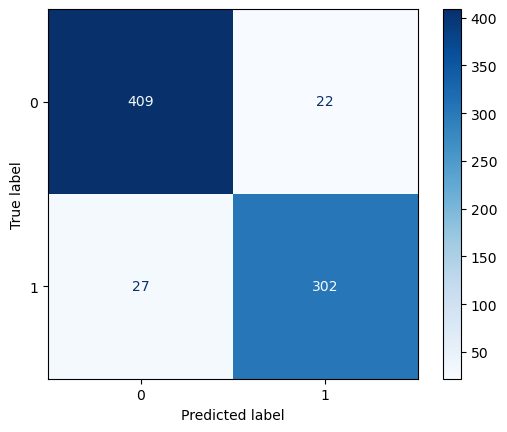

In [171]:
# confusion Matrix
cm = confusion_matrix(test[target], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)


These are amazing results compared to the prior run! The Precision/Recall score is balanced nicely despite a slight class imbalance of more Draws or Away wins than Home wins.

From a percentage standpoint we were stronger at predicting a game would not be a Home win (409/431) than it would (302 / 329) but its both in the low 90% range.

I will try the Win/Draw/Loss now

## Predicting Home Win/ Draw / Away Win

In [173]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Result']

In [174]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

In [175]:
preds_wdl = rf.predict(test[features])

### Home/Draw/Away - Model Evaluation

In [176]:
# Accuracy score
print(accuracy_score(test[target], preds_wdl))

# classification report
print(classification_report(test[target], preds_wdl))

0.8828947368421053
              precision    recall  f1-score   support

          -1       0.94      0.83      0.88       231
           0       0.98      0.78      0.87       200
           1       0.82      0.99      0.89       329

    accuracy                           0.88       760
   macro avg       0.91      0.86      0.88       760
weighted avg       0.90      0.88      0.88       760



You can even see in the testing portion here the breakdown of result frequencies

-1 (Away win) was 231 / 760 = 30.4%
0 (Draw) was 200 / 760 = 26.3%
1 (Home win) was 329 / 43.2%

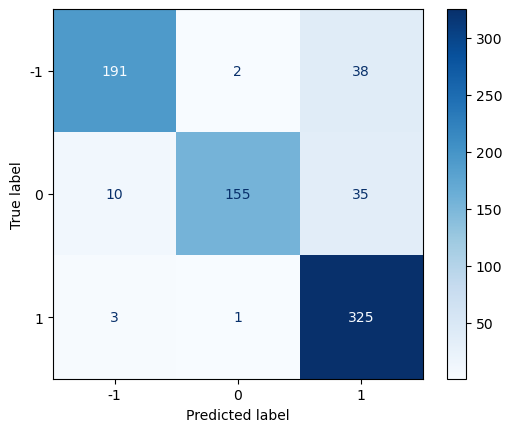

In [177]:
# confusion matrix 
cm = confusion_matrix(test[target], preds_wdl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

These are incredible results compared to the 52% I was finding before in V2. I do not know exactly what prompted the huge uptick. Whether the time series fix for the training/testing dataset helped, or the venue codes (recognizing the importance of some teams' home performance) balanced with recent form and a particular manager gave enough rules for a RF classifier to break through.

We still see a slight tendency towards predicting home wins rather than draws or losses as we saw in V1 and 2.

In [185]:
# feature importance

importances = rf.feature_importances_
feature_names = v3[features].columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))


             Feature  Importance
4  Away Manager Code    0.156711
2            Away ID    0.148117
3  Home Manager Code    0.133166
7    away_pts_last_5    0.129518
6    home_pts_last_5    0.128328
1            Home ID    0.123545
0         Venue Code    0.113222
5           Day Code    0.067394


### Combine predictions with the test set

In [186]:
test.index

Index([2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289,
       ...
       3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039],
      dtype='int64', length=760)

In [187]:
v3.index

RangeIndex(start=0, stop=3040, step=1)

In [192]:
# Ensure target column is 1-dimensional
actual_results = test[target].squeeze()  # Converts (760, 1) to (760,) if needed

# Create a DataFrame for predictions and actual results
results_df = pd.DataFrame({
    'Actual Result': actual_results,  # Ensure this is 1D
    'Predicted Result': preds_wdl.squeeze()  # Ensure predictions are 1D
}, index=test.index)  # Retain the same index as the test set

# Extract human-readable columns using test.index from v3
original_columns = ['date', 'Venue', 'home_team', 'Home GF', 'Away GF', 'away_team', 'Home Manager', 'Away Manager', 'Day']
readable_columns = v3.loc[test.index, original_columns]

# Combine readable columns and prediction results
results_with_details = pd.concat([results_df, readable_columns], axis=1)

# Display the head of the results DataFrame
results_with_details


,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,Day
2280,1,1,2014-08-16,Emirates Stadium,Arsenal,2,1,Crystal Palace,Arsène Wenger,Tony Pulis,Saturday
2281,-1,-1,2014-08-18,Turf Moor,Burnley,1,3,Chelsea,Sean Dyche,José Mourinho,Monday
2282,0,0,2014-08-16,King Power Stadium,Leicester City,2,2,Everton,Nigel Pearson,Roberto Martínez,Saturday
2283,1,1,2014-08-17,Anfield,Liverpool,2,1,Southampton,Brendan Rodgers,Ronald Koeman,Sunday
2284,-1,1,2014-08-16,Old Trafford,Manchester United,1,2,Swansea City,Louis van Gaal,Garry Monk,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
3035,0,0,2015-10-17,St Mary's Stadium,Southampton,2,2,Leicester City,Ronald Koeman,Claudio Ranieri,Saturday
3036,-1,-1,2015-10-19,Swansea.com Stadium,Swansea City,0,1,Stoke City,Garry Monk,Mark Hughes,Monday
3037,0,0,2015-10-17,White Hart Lane,Tottenham Hotspur,0,0,Liverpool,Mauricio Pochettino,Jürgen Klopp,Saturday
3038,-1,-1,2015-10-17,Vicarage Road,Watford,0,3,Arsenal,Quique Sánchez Flores,Arsène Wenger,Saturday


### Results we missed

- Which results did we mis-predict?

In [ ]:
# saving to csv
results_with_details.to_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/v3_results_details.csv', index=False)

In [195]:
# which results were predicted incorrectly
incorrect = results_with_details[results_with_details['Actual Result'] != results_with_details['Predicted Result']]

incorrect

,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,Day
2284,-1,1,2014-08-16,Old Trafford,Manchester United,1,2,Swansea City,Louis van Gaal,Garry Monk,Saturday
2294,0,1,2014-11-01,Goodison Park,Everton,0,0,Swansea City,Roberto Martínez,Garry Monk,Saturday
2301,-1,1,2014-11-08,Anfield,Liverpool,1,2,Chelsea,Brendan Rodgers,José Mourinho,Saturday
2307,-1,1,2014-11-09,White Hart Lane,Tottenham Hotspur,1,2,Stoke City,Mauricio Pochettino,Mark Hughes,Sunday
2325,0,-1,2014-11-29,Stadium of Light,Sunderland,0,0,Chelsea,Gus Poyet,José Mourinho,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
2983,-1,1,2015-08-29,Anfield,Liverpool,0,3,West Ham United,Brendan Rodgers,Slaven Bilić,Saturday
2987,-1,0,2015-08-29,bet365 Stadium,Stoke City,0,1,West Bromwich Albion,Mark Hughes,Tony Pulis,Saturday
3003,0,1,2015-09-20,Anfield,Liverpool,1,1,Norwich City,Brendan Rodgers,Alex Neil,Sunday
3004,-1,1,2015-09-19,Etihad Stadium,Manchester City,1,2,West Ham United,Manuel Pellegrini,Slaven Bilić,Saturday


Note: Below was with a run with id in the training data. It is meant to have no analytical value in it, as it's just an identifier column but it is improving the model's performance.

Until I can determine why, the below is just for illustration about the results we got incorrect. It is not taken as a legitimate run because there's a chance some data leakage is occurring.

In [ ]:
results_det = results_with_details[['id', 'date', 'Venue', 'home_team', 'Home GF', 'Away Manager', 'away_team', 'Home Manager', 'Away Manager', 'Day', 'home_pts_last_5_x', 'away_pts_last_5_x', 'Actual Result', 'Predicted Result']]

results_det

,id,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,Day,home_pts_last_5_x,away_pts_last_5_x,Actual Result,Predicted Result
0,4009,2014-08-16,Emirates Stadium,Arsenal,2,1,Crystal Palace,Arsène Wenger,Tony Pulis,Saturday,0,0,1,1
1,4010,2014-08-18,Turf Moor,Burnley,1,3,Chelsea,Sean Dyche,José Mourinho,Monday,0,0,-1,-1
2,4011,2014-08-16,King Power Stadium,Leicester City,2,2,Everton,Nigel Pearson,Roberto Martínez,Saturday,0,0,0,0
3,4012,2014-08-17,Anfield,Liverpool,2,1,Southampton,Brendan Rodgers,Ronald Koeman,Sunday,0,0,1,1
4,4013,2014-08-16,Old Trafford,Manchester United,1,2,Swansea City,Louis van Gaal,Garry Monk,Saturday,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,4764,2015-10-17,St Mary's Stadium,Southampton,2,2,Leicester City,Ronald Koeman,Claudio Ranieri,Saturday,10,8,0,0
756,4765,2015-10-19,Swansea.com Stadium,Swansea City,0,1,Stoke City,Garry Monk,Mark Hughes,Monday,5,7,-1,-1
757,4766,2015-10-17,White Hart Lane,Tottenham Hotspur,0,0,Liverpool,Mauricio Pochettino,Jürgen Klopp,Saturday,11,5,0,0
758,4767,2015-10-17,Vicarage Road,Watford,0,3,Arsenal,Quique Sánchez Flores,Arsène Wenger,Saturday,7,12,-1,-1


### Results we missed

- Which results did we get wrong here?

In [138]:
results_det[results_det['Actual Result'] != results_det['Predicted Result']]

,id,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,Day,home_pts_last_5_x,away_pts_last_5_x,Actual Result,Predicted Result
8,4017,2014-08-16,The Hawthorns,West Bromwich Albion,2,2,Sunderland,Alan Irvine,Gus Poyet,Saturday,0,0,0,-1
14,4023,2014-11-01,Goodison Park,Everton,0,0,Swansea City,Roberto Martínez,Garry Monk,Saturday,7,5,0,1
23,4032,2014-11-08,Loftus Road,Queens Park Rangers,2,2,Manchester City,Harry Redknapp,Manuel Pellegrini,Saturday,3,12,0,-1
29,4038,2014-11-08,Upton Park,West Ham United,0,0,Aston Villa,Sam Allardyce,Paul Lambert,Saturday,10,0,0,1
45,4054,2014-11-29,Stadium of Light,Sunderland,0,0,Chelsea,Gus Poyet,José Mourinho,Saturday,5,13,0,-1
81,4090,2014-12-20,MKM Stadium,Hull City,0,1,Swansea City,Steve Bruce,Garry Monk,Saturday,2,4,-1,1
106,4115,2014-12-28,St Mary's Stadium,Southampton,1,1,Chelsea,Ronald Koeman,José Mourinho,Sunday,6,12,0,-1
143,4152,2015-01-17,King Power Stadium,Leicester City,0,1,Stoke City,Nigel Pearson,Mark Hughes,Saturday,7,7,-1,1
144,4153,2015-01-18,Etihad Stadium,Manchester City,0,2,Arsenal,Manuel Pellegrini,Arsène Wenger,Sunday,11,10,-1,1
151,4160,2015-01-31,Stamford Bridge,Chelsea,1,1,Manchester City,José Mourinho,Manuel Pellegrini,Saturday,10,8,0,1


## V2

In [ ]:
df.sample(5)

,PC1,PC2,PC3,PC4,p(Home),p(Draw),p(Away),Result
2964,0.005641,-0.282010,-1.129980,0.930118,0.457,0.258,0.285,1
1895,-0.403886,0.500769,-0.961058,-0.194123,0.457,0.258,0.285,1
2657,-0.857472,-0.891843,-0.075507,0.028527,0.457,0.258,0.285,-1
1584,-2.036530,0.256216,-0.330386,-0.645570,0.457,0.258,0.285,1
1453,-2.132244,1.370095,-1.306988,1.773362,0.457,0.258,0.285,1


## Train the model

In [ ]:
# Step 1: Split data into features (X) and target (y)
X_pca = df.drop('Result', axis=1)
y_pca = df['Result']

In [ ]:
# Step 2: Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,  # Number of trees
    max_depth=5,       # Limit depth of each tree (same as decision tree for comparability)
    n_jobs=-1          # Use all available CPU cores for training
)
rf_model.fit(X_train_pca, y_train_pca)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [ ]:
# Step 4: Evaluate the Random Forest Model
y_pred_pca_rf = rf_model.predict(X_test_pca)

In [ ]:
# Accuracy and classification report
print("PCA Run Random Forest:")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca_rf))
print(classification_report(y_test_pca, y_pred_pca_rf))

PCA Run Random Forest:
Accuracy: 0.5164473684210527
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       177
           0       0.60      0.02      0.04       152
           1       0.53      0.80      0.64       279

    accuracy                           0.52       608
   macro avg       0.54      0.44      0.39       608
weighted avg       0.53      0.52      0.44       608



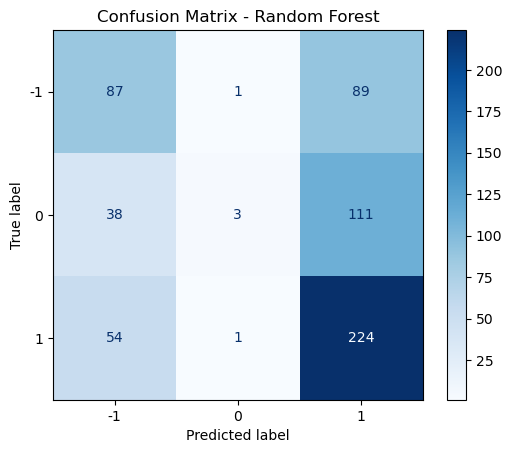

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_pred_pca_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
# print the cm
print(cm_pca_tree)


[[194   9  76]
 [ 79   5  68]
 [ 69   1 107]]


## Initial analysis

V2

__________


V1

With chance being 0.33, the initial performance of 50.33% is slightly worse than the logistic regression but its performance differs in that:
- It is slightly stronger in predicting away wins
- It is slightly weaker in predicting home wins
- It is willing to bet on draws occurring

The recall scores being higher than the precision scores shows that we will get a lot of false positives for the home win or away win.

However...**it is struggling with draws**

### V2 Feature importance


In [ ]:
importances = rf_model.feature_importances_
feature_names = X_pca.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

PC1: 0.1748
PC2: 0.5453
PC3: 0.1287
PC4: 0.1511
p(Home): 0.0000
p(Draw): 0.0000
p(Away): 0.0000


PC2 is clearly the most important feature contributing to predictions here, From the loadings in the previous workbook, this is the PC most related to differences between the home and away team.

PC1 has a lot of variance too and it is the next most important feature but less than 1/3 as important as PC2.